<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[17:15:34] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


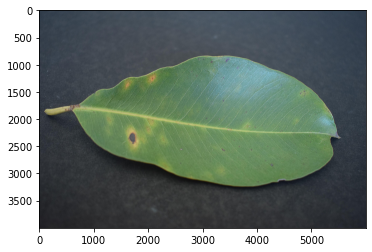

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

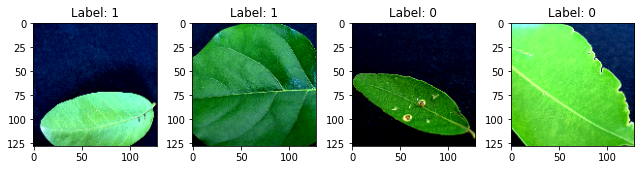

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[17:15:40] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

[17:15:41] /work/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


[17:15:42] /work/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


Epoch[1] Batch[5] Speed: 1.0832614213779732 samples/sec                   batch loss = 0.39866727590560913 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.2770897374444787 samples/sec                   batch loss = 1.835821509361267 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2789478382461694 samples/sec                   batch loss = 0.5438992977142334 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.271086817892508 samples/sec                   batch loss = 0.9608504176139832 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.2710276918647927 samples/sec                   batch loss = 0.6297445297241211 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2746562890300057 samples/sec                   batch loss = 0.40072691440582275 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.247180258157117 samples/sec                   batch loss = 1.0010435581207275 | accuracy = 0.6214285714285714


Epoch[1] Batch[40] Speed: 1.269014147468634 samples/sec                   batch loss = 0.9833619594573975 | accuracy = 0.625


Epoch[1] Batch[45] Speed: 1.2681136596765985 samples/sec                   batch loss = 0.5493555665016174 | accuracy = 0.6166666666666667


Epoch[1] Batch[50] Speed: 1.2707617890477756 samples/sec                   batch loss = 0.6986953616142273 | accuracy = 0.635


Epoch[1] Batch[55] Speed: 1.267637171959565 samples/sec                   batch loss = 0.6971042156219482 | accuracy = 0.6318181818181818


Epoch[1] Batch[60] Speed: 1.2713760754307255 samples/sec                   batch loss = 1.1402950286865234 | accuracy = 0.6291666666666667


Epoch[1] Batch[65] Speed: 1.2689072268089712 samples/sec                   batch loss = 0.10690850019454956 | accuracy = 0.6423076923076924


Epoch[1] Batch[70] Speed: 1.2715389189580018 samples/sec                   batch loss = 0.732661247253418 | accuracy = 0.6428571428571429


Epoch[1] Batch[75] Speed: 1.2696504771476829 samples/sec                   batch loss = 0.8142671585083008 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.2742243239357494 samples/sec                   batch loss = 0.4542742073535919 | accuracy = 0.6375


Epoch[1] Batch[85] Speed: 1.2720139086489388 samples/sec                   batch loss = 0.7820053100585938 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.2683716470837807 samples/sec                   batch loss = 0.7230066061019897 | accuracy = 0.6277777777777778


Epoch[1] Batch[95] Speed: 1.2756170129550595 samples/sec                   batch loss = 0.3317660093307495 | accuracy = 0.6289473684210526


Epoch[1] Batch[100] Speed: 1.278089476995638 samples/sec                   batch loss = 0.7234372496604919 | accuracy = 0.6275


Epoch[1] Batch[105] Speed: 1.2718817975566568 samples/sec                   batch loss = 0.3720932900905609 | accuracy = 0.6357142857142857


Epoch[1] Batch[110] Speed: 1.2714599972702272 samples/sec                   batch loss = 0.6011322736740112 | accuracy = 0.6386363636363637


Epoch[1] Batch[115] Speed: 1.272716969581341 samples/sec                   batch loss = 0.6970894932746887 | accuracy = 0.6391304347826087


Epoch[1] Batch[120] Speed: 1.2793778416166333 samples/sec                   batch loss = 0.3680785298347473 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.276461663694229 samples/sec                   batch loss = 0.6303604245185852 | accuracy = 0.642


Epoch[1] Batch[130] Speed: 1.2696134861077604 samples/sec                   batch loss = 0.8238831758499146 | accuracy = 0.65


Epoch[1] Batch[135] Speed: 1.2763898010943626 samples/sec                   batch loss = 0.6184558868408203 | accuracy = 0.6518518518518519


Epoch[1] Batch[140] Speed: 1.2730991251644377 samples/sec                   batch loss = 0.2905694544315338 | accuracy = 0.6517857142857143


Epoch[1] Batch[145] Speed: 1.273056233501777 samples/sec                   batch loss = 2.047912120819092 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.2674769540421056 samples/sec                   batch loss = 0.5994036793708801 | accuracy = 0.6383333333333333


Epoch[1] Batch[155] Speed: 1.2706819051606502 samples/sec                   batch loss = 0.8493141531944275 | accuracy = 0.635483870967742


Epoch[1] Batch[160] Speed: 1.276664282099224 samples/sec                   batch loss = 0.1958731710910797 | accuracy = 0.6390625


Epoch[1] Batch[165] Speed: 1.2677211756581626 samples/sec                   batch loss = 0.8604622483253479 | accuracy = 0.6303030303030303


Epoch[1] Batch[170] Speed: 1.2720327150137505 samples/sec                   batch loss = 0.6477184891700745 | accuracy = 0.625


Epoch[1] Batch[175] Speed: 1.2680654484768596 samples/sec                   batch loss = 0.3633849620819092 | accuracy = 0.6285714285714286


Epoch[1] Batch[180] Speed: 1.269142015216043 samples/sec                   batch loss = 0.6764471530914307 | accuracy = 0.6277777777777778


Epoch[1] Batch[185] Speed: 1.269842096407605 samples/sec                   batch loss = 0.4669196605682373 | accuracy = 0.6297297297297297


Epoch[1] Batch[190] Speed: 1.273505000133596 samples/sec                   batch loss = 0.46220412850379944 | accuracy = 0.6355263157894737


Epoch[1] Batch[195] Speed: 1.2725536311456316 samples/sec                   batch loss = 0.917189359664917 | accuracy = 0.6358974358974359


Epoch[1] Batch[200] Speed: 1.2754361548539122 samples/sec                   batch loss = 0.6390608549118042 | accuracy = 0.63625


Epoch[1] Batch[205] Speed: 1.273705230429722 samples/sec                   batch loss = 0.6900515556335449 | accuracy = 0.6353658536585366


Epoch[1] Batch[210] Speed: 1.269988684778893 samples/sec                   batch loss = 0.5831394195556641 | accuracy = 0.638095238095238


Epoch[1] Batch[215] Speed: 1.2719262493934984 samples/sec                   batch loss = 0.42525413632392883 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2748424476264733 samples/sec                   batch loss = 0.6545119881629944 | accuracy = 0.6443181818181818


Epoch[1] Batch[225] Speed: 1.2683343469848058 samples/sec                   batch loss = 0.9093005657196045 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.2723237541083425 samples/sec                   batch loss = 0.5176753401756287 | accuracy = 0.6478260869565218


Epoch[1] Batch[235] Speed: 1.2753985350552195 samples/sec                   batch loss = 0.4388634264469147 | accuracy = 0.6457446808510638


Epoch[1] Batch[240] Speed: 1.273747488904107 samples/sec                   batch loss = 0.6219263672828674 | accuracy = 0.6458333333333334


Epoch[1] Batch[245] Speed: 1.2737648959560743 samples/sec                   batch loss = 0.5262078046798706 | accuracy = 0.65


Epoch[1] Batch[250] Speed: 1.2737971969685582 samples/sec                   batch loss = 0.9232059717178345 | accuracy = 0.649


Epoch[1] Batch[255] Speed: 1.2697373425043057 samples/sec                   batch loss = 0.492438405752182 | accuracy = 0.6460784313725491


Epoch[1] Batch[260] Speed: 1.2749912586289929 samples/sec                   batch loss = 0.31119897961616516 | accuracy = 0.6442307692307693


Epoch[1] Batch[265] Speed: 1.2700741542063805 samples/sec                   batch loss = 0.6399508714675903 | accuracy = 0.6433962264150943


Epoch[1] Batch[270] Speed: 1.27917553139578 samples/sec                   batch loss = 0.5664044618606567 | accuracy = 0.6462962962962963


Epoch[1] Batch[275] Speed: 1.2688297829699022 samples/sec                   batch loss = 0.4055487811565399 | accuracy = 0.6481818181818182


Epoch[1] Batch[280] Speed: 1.2729421596095805 samples/sec                   batch loss = 0.8502843976020813 | accuracy = 0.6482142857142857


Epoch[1] Batch[285] Speed: 1.278350078713867 samples/sec                   batch loss = 0.8629308938980103 | accuracy = 0.6508771929824562


Epoch[1] Batch[290] Speed: 1.274081206917632 samples/sec                   batch loss = 0.9383325576782227 | accuracy = 0.6474137931034483


Epoch[1] Batch[295] Speed: 1.2712531513821224 samples/sec                   batch loss = 0.7169694900512695 | accuracy = 0.6449152542372881


Epoch[1] Batch[300] Speed: 1.2719501640314683 samples/sec                   batch loss = 0.6190475821495056 | accuracy = 0.6458333333333334


Epoch[1] Batch[305] Speed: 1.2689670195353508 samples/sec                   batch loss = 0.6065983772277832 | accuracy = 0.6467213114754098


Epoch[1] Batch[310] Speed: 1.2765877341258927 samples/sec                   batch loss = 0.183272123336792 | accuracy = 0.6508064516129032


Epoch[1] Batch[315] Speed: 1.2761446551472078 samples/sec                   batch loss = 0.5533087253570557 | accuracy = 0.6523809523809524


Epoch[1] Batch[320] Speed: 1.2799699225817753 samples/sec                   batch loss = 0.3772351145744324 | accuracy = 0.65234375


Epoch[1] Batch[325] Speed: 1.2778319985973505 samples/sec                   batch loss = 0.5032651424407959 | accuracy = 0.6538461538461539


Epoch[1] Batch[330] Speed: 1.2725384771633976 samples/sec                   batch loss = 0.6650487780570984 | accuracy = 0.6545454545454545


Epoch[1] Batch[335] Speed: 1.2775756940717353 samples/sec                   batch loss = 1.0562926530838013 | accuracy = 0.6544776119402985


Epoch[1] Batch[340] Speed: 1.2708465924524637 samples/sec                   batch loss = 1.0849298238754272 | accuracy = 0.6544117647058824


Epoch[1] Batch[345] Speed: 1.2756359260133086 samples/sec                   batch loss = 0.897263765335083 | accuracy = 0.6536231884057971


Epoch[1] Batch[350] Speed: 1.2776934218027727 samples/sec                   batch loss = 0.6319885849952698 | accuracy = 0.6528571428571428


Epoch[1] Batch[355] Speed: 1.2771226933947795 samples/sec                   batch loss = 0.6793489456176758 | accuracy = 0.6528169014084507


Epoch[1] Batch[360] Speed: 1.2704729071373275 samples/sec                   batch loss = 0.5828829407691956 | accuracy = 0.6527777777777778


Epoch[1] Batch[365] Speed: 1.274352082304903 samples/sec                   batch loss = 0.4555504024028778 | accuracy = 0.6534246575342466


Epoch[1] Batch[370] Speed: 1.2720911629585652 samples/sec                   batch loss = 0.29865095019340515 | accuracy = 0.652027027027027


Epoch[1] Batch[375] Speed: 1.281735259413016 samples/sec                   batch loss = 0.499722421169281 | accuracy = 0.654


Epoch[1] Batch[380] Speed: 1.272084121914997 samples/sec                   batch loss = 0.40085700154304504 | accuracy = 0.6539473684210526


Epoch[1] Batch[385] Speed: 1.2759312364281474 samples/sec                   batch loss = 0.9636591672897339 | accuracy = 0.6538961038961039


Epoch[1] Batch[390] Speed: 1.2722781167037949 samples/sec                   batch loss = 0.4693070948123932 | accuracy = 0.6557692307692308


Epoch[1] Batch[395] Speed: 1.2713994876425305 samples/sec                   batch loss = 0.40624842047691345 | accuracy = 0.6531645569620254


Epoch[1] Batch[400] Speed: 1.2718697449910112 samples/sec                   batch loss = 0.6169514656066895 | accuracy = 0.6525


Epoch[1] Batch[405] Speed: 1.272530948567566 samples/sec                   batch loss = 0.3428128957748413 | accuracy = 0.6549382716049382


Epoch[1] Batch[410] Speed: 1.2640059922922018 samples/sec                   batch loss = 0.46068912744522095 | accuracy = 0.6554878048780488


Epoch[1] Batch[415] Speed: 1.2702029088385058 samples/sec                   batch loss = 0.557245135307312 | accuracy = 0.6560240963855422


Epoch[1] Batch[420] Speed: 1.2687086939569499 samples/sec                   batch loss = 0.560297429561615 | accuracy = 0.656547619047619


Epoch[1] Batch[425] Speed: 1.2723370696551781 samples/sec                   batch loss = 0.39107367396354675 | accuracy = 0.658235294117647


Epoch[1] Batch[430] Speed: 1.2686506523481456 samples/sec                   batch loss = 0.8341371417045593 | accuracy = 0.6593023255813953


Epoch[1] Batch[435] Speed: 1.2696981363141933 samples/sec                   batch loss = 0.4926699101924896 | accuracy = 0.6597701149425287


Epoch[1] Batch[440] Speed: 1.2739462477082437 samples/sec                   batch loss = 0.427117258310318 | accuracy = 0.6607954545454545


Epoch[1] Batch[445] Speed: 1.2775507891670084 samples/sec                   batch loss = 0.9283460974693298 | accuracy = 0.6601123595505618


Epoch[1] Batch[450] Speed: 1.2798049125507145 samples/sec                   batch loss = 0.7489725351333618 | accuracy = 0.66


Epoch[1] Batch[455] Speed: 1.273681733223405 samples/sec                   batch loss = 0.7220243811607361 | accuracy = 0.660989010989011


Epoch[1] Batch[460] Speed: 1.2702872529447276 samples/sec                   batch loss = 0.8525720238685608 | accuracy = 0.6614130434782609


Epoch[1] Batch[465] Speed: 1.2668164949661738 samples/sec                   batch loss = 0.8201797604560852 | accuracy = 0.6612903225806451


Epoch[1] Batch[470] Speed: 1.2752503075018595 samples/sec                   batch loss = 0.8098931312561035 | accuracy = 0.6611702127659574


Epoch[1] Batch[475] Speed: 1.2772466579954787 samples/sec                   batch loss = 0.5405528545379639 | accuracy = 0.6626315789473685


Epoch[1] Batch[480] Speed: 1.2690106919411634 samples/sec                   batch loss = 0.6347336173057556 | accuracy = 0.6640625


Epoch[1] Batch[485] Speed: 1.2695693879183378 samples/sec                   batch loss = 0.23286573588848114 | accuracy = 0.6659793814432989


Epoch[1] Batch[490] Speed: 1.266645104457428 samples/sec                   batch loss = 0.4531736671924591 | accuracy = 0.6653061224489796


Epoch[1] Batch[495] Speed: 1.2668435659001243 samples/sec                   batch loss = 0.46516698598861694 | accuracy = 0.6656565656565656


Epoch[1] Batch[500] Speed: 1.2727157144571573 samples/sec                   batch loss = 1.0842573642730713 | accuracy = 0.665


Epoch[1] Batch[505] Speed: 1.2724140737180671 samples/sec                   batch loss = 0.3297702670097351 | accuracy = 0.6653465346534654


Epoch[1] Batch[510] Speed: 1.2724526757529404 samples/sec                   batch loss = 0.6940599679946899 | accuracy = 0.6651960784313725


Epoch[1] Batch[515] Speed: 1.2674520583006843 samples/sec                   batch loss = 0.5774272680282593 | accuracy = 0.6674757281553398


Epoch[1] Batch[520] Speed: 1.2666382192007108 samples/sec                   batch loss = 0.7192766070365906 | accuracy = 0.6673076923076923


Epoch[1] Batch[525] Speed: 1.2716693202072453 samples/sec                   batch loss = 0.5449240207672119 | accuracy = 0.6666666666666666


Epoch[1] Batch[530] Speed: 1.269987819567916 samples/sec                   batch loss = 0.6795048117637634 | accuracy = 0.6660377358490566


Epoch[1] Batch[535] Speed: 1.2732592215998813 samples/sec                   batch loss = 0.6103506088256836 | accuracy = 0.6654205607476635


Epoch[1] Batch[540] Speed: 1.2773658811643989 samples/sec                   batch loss = 0.40899229049682617 | accuracy = 0.6666666666666666


Epoch[1] Batch[545] Speed: 1.2781420562288415 samples/sec                   batch loss = 0.5714602470397949 | accuracy = 0.6669724770642201


Epoch[1] Batch[550] Speed: 1.2735945207218151 samples/sec                   batch loss = 1.0842571258544922 | accuracy = 0.6654545454545454


Epoch[1] Batch[555] Speed: 1.272966209051184 samples/sec                   batch loss = 0.9772617816925049 | accuracy = 0.6653153153153153


Epoch[1] Batch[560] Speed: 1.2668578192596154 samples/sec                   batch loss = 0.5082478523254395 | accuracy = 0.6674107142857143


Epoch[1] Batch[565] Speed: 1.2650923681987456 samples/sec                   batch loss = 0.3548884987831116 | accuracy = 0.6672566371681415


Epoch[1] Batch[570] Speed: 1.2752728932557047 samples/sec                   batch loss = 0.4990718364715576 | accuracy = 0.668859649122807


Epoch[1] Batch[575] Speed: 1.2720815177131488 samples/sec                   batch loss = 0.5086362957954407 | accuracy = 0.67


Epoch[1] Batch[580] Speed: 1.272165532712174 samples/sec                   batch loss = 0.6662412285804749 | accuracy = 0.6698275862068965


Epoch[1] Batch[585] Speed: 1.264714526993283 samples/sec                   batch loss = 0.8682098388671875 | accuracy = 0.6696581196581196


Epoch[1] Batch[590] Speed: 1.2605912116952986 samples/sec                   batch loss = 0.6716919541358948 | accuracy = 0.6703389830508475


Epoch[1] Batch[595] Speed: 1.2688463841368791 samples/sec                   batch loss = 0.5199427604675293 | accuracy = 0.6710084033613445


Epoch[1] Batch[600] Speed: 1.2668414614044203 samples/sec                   batch loss = 0.6920589208602905 | accuracy = 0.6708333333333333


Epoch[1] Batch[605] Speed: 1.2688353486306556 samples/sec                   batch loss = 0.2769605219364166 | accuracy = 0.671900826446281


Epoch[1] Batch[610] Speed: 1.2643082325248205 samples/sec                   batch loss = 0.4900517463684082 | accuracy = 0.6704918032786885


Epoch[1] Batch[615] Speed: 1.2629735798241797 samples/sec                   batch loss = 0.4626843333244324 | accuracy = 0.6707317073170732


Epoch[1] Batch[620] Speed: 1.2661757396395223 samples/sec                   batch loss = 2.1634480953216553 | accuracy = 0.6717741935483871


Epoch[1] Batch[625] Speed: 1.2680628607030058 samples/sec                   batch loss = 0.543565571308136 | accuracy = 0.6724


Epoch[1] Batch[630] Speed: 1.2690248981188916 samples/sec                   batch loss = 0.7693977952003479 | accuracy = 0.6730158730158731


Epoch[1] Batch[635] Speed: 1.2646509398790107 samples/sec                   batch loss = 0.6156777143478394 | accuracy = 0.6748031496062992


Epoch[1] Batch[640] Speed: 1.269183683396421 samples/sec                   batch loss = 0.46487775444984436 | accuracy = 0.6765625


Epoch[1] Batch[645] Speed: 1.2690177949902695 samples/sec                   batch loss = 0.670654296875 | accuracy = 0.6755813953488372


Epoch[1] Batch[650] Speed: 1.2770664068265427 samples/sec                   batch loss = 0.5416260361671448 | accuracy = 0.6757692307692308


Epoch[1] Batch[655] Speed: 1.2685298852629225 samples/sec                   batch loss = 0.5093178749084473 | accuracy = 0.6755725190839694


Epoch[1] Batch[660] Speed: 1.2674353021023124 samples/sec                   batch loss = 0.4513869285583496 | accuracy = 0.6757575757575758


Epoch[1] Batch[665] Speed: 1.2677288390354202 samples/sec                   batch loss = 0.7836818099021912 | accuracy = 0.6755639097744361


Epoch[1] Batch[670] Speed: 1.2645605751916564 samples/sec                   batch loss = 0.1472865790128708 | accuracy = 0.6764925373134328


Epoch[1] Batch[675] Speed: 1.2680534681310907 samples/sec                   batch loss = 0.5813989043235779 | accuracy = 0.6777777777777778


Epoch[1] Batch[680] Speed: 1.2654313012097282 samples/sec                   batch loss = 0.5623378753662109 | accuracy = 0.6790441176470589


Epoch[1] Batch[685] Speed: 1.266221322554427 samples/sec                   batch loss = 0.8027307391166687 | accuracy = 0.6791970802919708


Epoch[1] Batch[690] Speed: 1.2689215266433786 samples/sec                   batch loss = 0.4632191061973572 | accuracy = 0.6800724637681159


Epoch[1] Batch[695] Speed: 1.270913307284125 samples/sec                   batch loss = 0.3285566568374634 | accuracy = 0.6820143884892086


Epoch[1] Batch[700] Speed: 1.2800573267861042 samples/sec                   batch loss = 0.9084634184837341 | accuracy = 0.6814285714285714


Epoch[1] Batch[705] Speed: 1.2759232794935675 samples/sec                   batch loss = 0.5741371512413025 | accuracy = 0.6812056737588652


Epoch[1] Batch[710] Speed: 1.2792075221954173 samples/sec                   batch loss = 0.12730275094509125 | accuracy = 0.6806338028169014


Epoch[1] Batch[715] Speed: 1.2745087180454877 samples/sec                   batch loss = 0.38056680560112 | accuracy = 0.6807692307692308


Epoch[1] Batch[720] Speed: 1.2740513102617865 samples/sec                   batch loss = 2.1383752822875977 | accuracy = 0.6809027777777777


Epoch[1] Batch[725] Speed: 1.2811988757485242 samples/sec                   batch loss = 0.843485951423645 | accuracy = 0.6813793103448276


Epoch[1] Batch[730] Speed: 1.2814935375426866 samples/sec                   batch loss = 0.526678204536438 | accuracy = 0.6818493150684931


Epoch[1] Batch[735] Speed: 1.2778766726643405 samples/sec                   batch loss = 0.5841543674468994 | accuracy = 0.6816326530612244


Epoch[1] Batch[740] Speed: 1.2753033319749632 samples/sec                   batch loss = 0.4879506826400757 | accuracy = 0.6820945945945946


Epoch[1] Batch[745] Speed: 1.2766053160335515 samples/sec                   batch loss = 0.3159959018230438 | accuracy = 0.6818791946308724


Epoch[1] Batch[750] Speed: 1.2740010019045602 samples/sec                   batch loss = 0.5643599629402161 | accuracy = 0.6833333333333333


Epoch[1] Batch[755] Speed: 1.272445244679189 samples/sec                   batch loss = 0.7462801933288574 | accuracy = 0.6844370860927153


Epoch[1] Batch[760] Speed: 1.277159928859979 samples/sec                   batch loss = 0.5824354887008667 | accuracy = 0.6848684210526316


Epoch[1] Batch[765] Speed: 1.2748177460369612 samples/sec                   batch loss = 0.8485932946205139 | accuracy = 0.6843137254901961


Epoch[1] Batch[770] Speed: 1.2765346999238594 samples/sec                   batch loss = 0.40826624631881714 | accuracy = 0.685064935064935


Epoch[1] Batch[775] Speed: 1.2736813464453687 samples/sec                   batch loss = 0.2984863221645355 | accuracy = 0.6867741935483871


Epoch[1] Batch[780] Speed: 1.2715463394496171 samples/sec                   batch loss = 0.8351649045944214 | accuracy = 0.6868589743589744


Epoch[1] Batch[785] Speed: 1.2744789949544135 samples/sec                   batch loss = 0.583743691444397 | accuracy = 0.6869426751592357


[Epoch 1] training: accuracy=0.6868654822335025
[Epoch 1] time cost: 649.9361910820007
[Epoch 1] validation: validation accuracy=0.7311111111111112


Epoch[2] Batch[5] Speed: 1.26595140867633 samples/sec                   batch loss = 0.405134916305542 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2722071102548111 samples/sec                   batch loss = 0.41395434737205505 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2755696842722466 samples/sec                   batch loss = 0.4832119047641754 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2690510075993067 samples/sec                   batch loss = 0.6802754402160645 | accuracy = 0.7125


Epoch[2] Batch[25] Speed: 1.2721416099750633 samples/sec                   batch loss = 0.28246912360191345 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2717225292861185 samples/sec                   batch loss = 0.5028089284896851 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2644880449496838 samples/sec                   batch loss = 0.49939191341400146 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2659395637654234 samples/sec                   batch loss = 0.594389796257019 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.270180406146634 samples/sec                   batch loss = 0.7561822533607483 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.2597657242861338 samples/sec                   batch loss = 0.4172670841217041 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2631002330949683 samples/sec                   batch loss = 0.3835156261920929 | accuracy = 0.75


Epoch[2] Batch[60] Speed: 1.2617607265578525 samples/sec                   batch loss = 0.44273048639297485 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2615374828662225 samples/sec                   batch loss = 0.24906224012374878 | accuracy = 0.7461538461538462


Epoch[2] Batch[70] Speed: 1.2619998072836693 samples/sec                   batch loss = 0.3676079213619232 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2637860469481772 samples/sec                   batch loss = 0.7428804636001587 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2667682866977528 samples/sec                   batch loss = 0.3432510495185852 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2665578967362074 samples/sec                   batch loss = 0.317571759223938 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.262016420068759 samples/sec                   batch loss = 0.968039333820343 | accuracy = 0.7388888888888889


Epoch[2] Batch[95] Speed: 1.2626598135559315 samples/sec                   batch loss = 1.2448794841766357 | accuracy = 0.7289473684210527


Epoch[2] Batch[100] Speed: 1.2650967563734923 samples/sec                   batch loss = 0.4410504102706909 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.2651861482112141 samples/sec                   batch loss = 0.4021469056606293 | accuracy = 0.7285714285714285


Epoch[2] Batch[110] Speed: 1.2618068462349799 samples/sec                   batch loss = 0.31890636682510376 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.2706227205653589 samples/sec                   batch loss = 0.6170333027839661 | accuracy = 0.7304347826086957


Epoch[2] Batch[120] Speed: 1.2653077108489708 samples/sec                   batch loss = 0.5496004223823547 | accuracy = 0.73125


Epoch[2] Batch[125] Speed: 1.2555048580684887 samples/sec                   batch loss = 0.41194581985473633 | accuracy = 0.732


Epoch[2] Batch[130] Speed: 1.258776300916966 samples/sec                   batch loss = 0.5628377199172974 | accuracy = 0.7269230769230769


Epoch[2] Batch[135] Speed: 1.2583148248608367 samples/sec                   batch loss = 0.7464331388473511 | accuracy = 0.7222222222222222


Epoch[2] Batch[140] Speed: 1.2608464313778303 samples/sec                   batch loss = 0.9904287457466125 | accuracy = 0.7178571428571429


Epoch[2] Batch[145] Speed: 1.257695083972574 samples/sec                   batch loss = 0.31157153844833374 | accuracy = 0.7172413793103448


Epoch[2] Batch[150] Speed: 1.2611386303280203 samples/sec                   batch loss = 0.5152992606163025 | accuracy = 0.7166666666666667


Epoch[2] Batch[155] Speed: 1.2609485860977718 samples/sec                   batch loss = 0.15333466231822968 | accuracy = 0.7193548387096774


Epoch[2] Batch[160] Speed: 1.2533439693505801 samples/sec                   batch loss = 0.8881976008415222 | accuracy = 0.71875


Epoch[2] Batch[165] Speed: 1.2585645916934307 samples/sec                   batch loss = 0.48663535714149475 | accuracy = 0.7227272727272728


Epoch[2] Batch[170] Speed: 1.262948195174888 samples/sec                   batch loss = 0.2542893886566162 | accuracy = 0.725


Epoch[2] Batch[175] Speed: 1.2617840706644132 samples/sec                   batch loss = 0.7747552990913391 | accuracy = 0.7257142857142858


Epoch[2] Batch[180] Speed: 1.2585723335950167 samples/sec                   batch loss = 0.7608224153518677 | accuracy = 0.725


Epoch[2] Batch[185] Speed: 1.2681678177816653 samples/sec                   batch loss = 0.3713432848453522 | accuracy = 0.727027027027027


Epoch[2] Batch[190] Speed: 1.2627774695159493 samples/sec                   batch loss = 0.4554620683193207 | accuracy = 0.7276315789473684


Epoch[2] Batch[195] Speed: 1.2604533186000606 samples/sec                   batch loss = 0.17329037189483643 | accuracy = 0.732051282051282


Epoch[2] Batch[200] Speed: 1.2642987049413346 samples/sec                   batch loss = 0.6639995574951172 | accuracy = 0.73375


Epoch[2] Batch[205] Speed: 1.2662284899780025 samples/sec                   batch loss = 0.46081629395484924 | accuracy = 0.7329268292682927


Epoch[2] Batch[210] Speed: 1.2687903449451452 samples/sec                   batch loss = 0.5108996629714966 | accuracy = 0.736904761904762


Epoch[2] Batch[215] Speed: 1.2682467147677519 samples/sec                   batch loss = 0.18547505140304565 | accuracy = 0.7395348837209302


Epoch[2] Batch[220] Speed: 1.2680206910620015 samples/sec                   batch loss = 0.7108780741691589 | accuracy = 0.7363636363636363


Epoch[2] Batch[225] Speed: 1.2670444817739996 samples/sec                   batch loss = 0.7936784029006958 | accuracy = 0.7355555555555555


Epoch[2] Batch[230] Speed: 1.2646514165202491 samples/sec                   batch loss = 0.5068911910057068 | accuracy = 0.7347826086956522


Epoch[2] Batch[235] Speed: 1.2647134782783716 samples/sec                   batch loss = 0.33192145824432373 | accuracy = 0.7372340425531915


Epoch[2] Batch[240] Speed: 1.2667252467013244 samples/sec                   batch loss = 0.2667444050312042 | accuracy = 0.7354166666666667


Epoch[2] Batch[245] Speed: 1.2735443451055026 samples/sec                   batch loss = 0.4824117422103882 | accuracy = 0.736734693877551


Epoch[2] Batch[250] Speed: 1.2666759934052458 samples/sec                   batch loss = 0.3461226522922516 | accuracy = 0.742


Epoch[2] Batch[255] Speed: 1.2682149822359967 samples/sec                   batch loss = 0.3936082124710083 | accuracy = 0.7441176470588236


Epoch[2] Batch[260] Speed: 1.263142932001819 samples/sec                   batch loss = 0.3686710596084595 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.2603728317689495 samples/sec                   batch loss = 0.6335403919219971 | accuracy = 0.7452830188679245


Epoch[2] Batch[270] Speed: 1.2662130084447327 samples/sec                   batch loss = 0.5367051362991333 | accuracy = 0.7444444444444445


Epoch[2] Batch[275] Speed: 1.2638104180720229 samples/sec                   batch loss = 0.11054515838623047 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2678656459082822 samples/sec                   batch loss = 0.6694193482398987 | accuracy = 0.74375


Epoch[2] Batch[285] Speed: 1.2675217688413662 samples/sec                   batch loss = 0.5697178244590759 | accuracy = 0.7429824561403509


Epoch[2] Batch[290] Speed: 1.2688773805419928 samples/sec                   batch loss = 0.13782653212547302 | accuracy = 0.743103448275862


Epoch[2] Batch[295] Speed: 1.2675919659110777 samples/sec                   batch loss = 0.35109177231788635 | accuracy = 0.7415254237288136


Epoch[2] Batch[300] Speed: 1.2720935742927735 samples/sec                   batch loss = 0.5641756653785706 | accuracy = 0.7408333333333333


Epoch[2] Batch[305] Speed: 1.2744310730203825 samples/sec                   batch loss = 0.5957197546958923 | accuracy = 0.7434426229508196


Epoch[2] Batch[310] Speed: 1.2728892347217133 samples/sec                   batch loss = 0.23547570407390594 | accuracy = 0.7435483870967742


Epoch[2] Batch[315] Speed: 1.2679180580434033 samples/sec                   batch loss = 0.3391401171684265 | accuracy = 0.7428571428571429


Epoch[2] Batch[320] Speed: 1.2661938959628731 samples/sec                   batch loss = 0.4610954523086548 | accuracy = 0.74453125


Epoch[2] Batch[325] Speed: 1.2696501888974807 samples/sec                   batch loss = 0.4418676793575287 | accuracy = 0.7438461538461538


Epoch[2] Batch[330] Speed: 1.2683964830707122 samples/sec                   batch loss = 0.42988961935043335 | accuracy = 0.7454545454545455


Epoch[2] Batch[335] Speed: 1.2667420797738995 samples/sec                   batch loss = 0.42649397253990173 | accuracy = 0.7470149253731343


Epoch[2] Batch[340] Speed: 1.2760276978945015 samples/sec                   batch loss = 0.8175588250160217 | accuracy = 0.7463235294117647


Epoch[2] Batch[345] Speed: 1.2708826926822203 samples/sec                   batch loss = 0.6653281450271606 | accuracy = 0.7427536231884058


Epoch[2] Batch[350] Speed: 1.2712330195362138 samples/sec                   batch loss = 0.4757574498653412 | accuracy = 0.7435714285714285


Epoch[2] Batch[355] Speed: 1.2761996955629336 samples/sec                   batch loss = 0.6052869558334351 | accuracy = 0.7443661971830986


Epoch[2] Batch[360] Speed: 1.2741318118981282 samples/sec                   batch loss = 0.7559562921524048 | accuracy = 0.74375


Epoch[2] Batch[365] Speed: 1.2723881151667438 samples/sec                   batch loss = 0.2817082405090332 | accuracy = 0.7445205479452055


Epoch[2] Batch[370] Speed: 1.2760246893185703 samples/sec                   batch loss = 0.08361784368753433 | accuracy = 0.7452702702702703


Epoch[2] Batch[375] Speed: 1.2710807509621436 samples/sec                   batch loss = 0.6559540033340454 | accuracy = 0.746


Epoch[2] Batch[380] Speed: 1.277820611589654 samples/sec                   batch loss = 0.24878540635108948 | accuracy = 0.7480263157894737


Epoch[2] Batch[385] Speed: 1.2719436067025418 samples/sec                   batch loss = 0.1898166984319687 | accuracy = 0.7467532467532467


Epoch[2] Batch[390] Speed: 1.2704473163404895 samples/sec                   batch loss = 0.4487294852733612 | accuracy = 0.7448717948717949


Epoch[2] Batch[395] Speed: 1.272749603679054 samples/sec                   batch loss = 1.0725445747375488 | accuracy = 0.7430379746835443


Epoch[2] Batch[400] Speed: 1.2751714090443658 samples/sec                   batch loss = 0.17471376061439514 | accuracy = 0.745625


Epoch[2] Batch[405] Speed: 1.2724957197836215 samples/sec                   batch loss = 0.655282199382782 | accuracy = 0.7450617283950617


Epoch[2] Batch[410] Speed: 1.270683060036862 samples/sec                   batch loss = 0.2575910687446594 | accuracy = 0.7451219512195122


Epoch[2] Batch[415] Speed: 1.2709668382453596 samples/sec                   batch loss = 0.18879303336143494 | accuracy = 0.7457831325301205


Epoch[2] Batch[420] Speed: 1.2685975081608627 samples/sec                   batch loss = 0.633735716342926 | accuracy = 0.7464285714285714


Epoch[2] Batch[425] Speed: 1.273401284132419 samples/sec                   batch loss = 0.3778245747089386 | accuracy = 0.7464705882352941


Epoch[2] Batch[430] Speed: 1.2736179180255192 samples/sec                   batch loss = 0.4907248318195343 | accuracy = 0.7453488372093023


Epoch[2] Batch[435] Speed: 1.2761991130998172 samples/sec                   batch loss = 0.28760597109794617 | accuracy = 0.7459770114942529


Epoch[2] Batch[440] Speed: 1.2772549231578554 samples/sec                   batch loss = 0.717785120010376 | accuracy = 0.7465909090909091


Epoch[2] Batch[445] Speed: 1.2764259256061044 samples/sec                   batch loss = 0.1902722716331482 | accuracy = 0.7471910112359551


Epoch[2] Batch[450] Speed: 1.2768815418216513 samples/sec                   batch loss = 0.11124689131975174 | accuracy = 0.7483333333333333


Epoch[2] Batch[455] Speed: 1.2745524822533938 samples/sec                   batch loss = 0.26530835032463074 | accuracy = 0.7472527472527473


Epoch[2] Batch[460] Speed: 1.272991418477509 samples/sec                   batch loss = 0.14243650436401367 | accuracy = 0.7472826086956522


Epoch[2] Batch[465] Speed: 1.2674700597388715 samples/sec                   batch loss = 0.6310633420944214 | accuracy = 0.7462365591397849


Epoch[2] Batch[470] Speed: 1.2679069428592977 samples/sec                   batch loss = 0.8721222281455994 | accuracy = 0.7446808510638298


Epoch[2] Batch[475] Speed: 1.2713519896929137 samples/sec                   batch loss = 1.1975953578948975 | accuracy = 0.7426315789473684


Epoch[2] Batch[480] Speed: 1.270863920306791 samples/sec                   batch loss = 0.5626620650291443 | accuracy = 0.7427083333333333


Epoch[2] Batch[485] Speed: 1.268727498658465 samples/sec                   batch loss = 0.44959965348243713 | accuracy = 0.743298969072165


Epoch[2] Batch[490] Speed: 1.2706048219199495 samples/sec                   batch loss = 0.5047141313552856 | accuracy = 0.7423469387755102


Epoch[2] Batch[495] Speed: 1.270133287707945 samples/sec                   batch loss = 0.41690635681152344 | accuracy = 0.7434343434343434


Epoch[2] Batch[500] Speed: 1.2759006706966873 samples/sec                   batch loss = 0.4576677083969116 | accuracy = 0.743


Epoch[2] Batch[505] Speed: 1.2709353545619302 samples/sec                   batch loss = 0.41650664806365967 | accuracy = 0.7415841584158416


Epoch[2] Batch[510] Speed: 1.2690215385211192 samples/sec                   batch loss = 0.2263091802597046 | accuracy = 0.7416666666666667


Epoch[2] Batch[515] Speed: 1.2796225722607146 samples/sec                   batch loss = 0.1985543668270111 | accuracy = 0.7422330097087378


Epoch[2] Batch[520] Speed: 1.2742805538191846 samples/sec                   batch loss = 0.3914257287979126 | accuracy = 0.74375


Epoch[2] Batch[525] Speed: 1.2703877688152705 samples/sec                   batch loss = 0.7216856479644775 | accuracy = 0.7423809523809524


Epoch[2] Batch[530] Speed: 1.266377304021068 samples/sec                   batch loss = 0.4987105131149292 | accuracy = 0.7415094339622641


Epoch[2] Batch[535] Speed: 1.2733840803157483 samples/sec                   batch loss = 0.2009037286043167 | accuracy = 0.7420560747663552


Epoch[2] Batch[540] Speed: 1.2691857956811927 samples/sec                   batch loss = 0.47022947669029236 | accuracy = 0.7425925925925926


Epoch[2] Batch[545] Speed: 1.2669710922559363 samples/sec                   batch loss = 0.4923095107078552 | accuracy = 0.7422018348623853


Epoch[2] Batch[550] Speed: 1.2704532810205418 samples/sec                   batch loss = 0.30418863892555237 | accuracy = 0.7427272727272727


Epoch[2] Batch[555] Speed: 1.2747652462300805 samples/sec                   batch loss = 0.31241685152053833 | accuracy = 0.7445945945945946


Epoch[2] Batch[560] Speed: 1.2754022193704626 samples/sec                   batch loss = 0.29005166888237 | accuracy = 0.74375


Epoch[2] Batch[565] Speed: 1.2656124834539724 samples/sec                   batch loss = 0.7165188193321228 | accuracy = 0.7433628318584071


Epoch[2] Batch[570] Speed: 1.2733316985230771 samples/sec                   batch loss = 0.6160980463027954 | accuracy = 0.743859649122807


Epoch[2] Batch[575] Speed: 1.2690279697667075 samples/sec                   batch loss = 0.07133390754461288 | accuracy = 0.7447826086956522


Epoch[2] Batch[580] Speed: 1.2790009756478362 samples/sec                   batch loss = 0.6112868785858154 | accuracy = 0.7452586206896552


Epoch[2] Batch[585] Speed: 1.2719390744705925 samples/sec                   batch loss = 0.4786207377910614 | accuracy = 0.7452991452991453


Epoch[2] Batch[590] Speed: 1.2704650181351491 samples/sec                   batch loss = 0.45620301365852356 | accuracy = 0.7461864406779661


Epoch[2] Batch[595] Speed: 1.2684295672667278 samples/sec                   batch loss = 0.732905924320221 | accuracy = 0.746218487394958


Epoch[2] Batch[600] Speed: 1.2671491746264971 samples/sec                   batch loss = 0.17238280177116394 | accuracy = 0.74625


Epoch[2] Batch[605] Speed: 1.2717983020722003 samples/sec                   batch loss = 0.3123340308666229 | accuracy = 0.7475206611570248


Epoch[2] Batch[610] Speed: 1.2658715553412723 samples/sec                   batch loss = 0.39716845750808716 | accuracy = 0.7467213114754099


Epoch[2] Batch[615] Speed: 1.2749201427873937 samples/sec                   batch loss = 0.09646732360124588 | accuracy = 0.7463414634146341


Epoch[2] Batch[620] Speed: 1.2769696910651482 samples/sec                   batch loss = 0.9058842658996582 | accuracy = 0.7455645161290323


Epoch[2] Batch[625] Speed: 1.26955094252558 samples/sec                   batch loss = 0.21635077893733978 | accuracy = 0.7448


Epoch[2] Batch[630] Speed: 1.2755466031149485 samples/sec                   batch loss = 0.20354920625686646 | accuracy = 0.746031746031746


Epoch[2] Batch[635] Speed: 1.2661803264510019 samples/sec                   batch loss = 0.5210427641868591 | accuracy = 0.7468503937007874


Epoch[2] Batch[640] Speed: 1.2714264657459293 samples/sec                   batch loss = 0.37062835693359375 | accuracy = 0.747265625


Epoch[2] Batch[645] Speed: 1.2720693649121733 samples/sec                   batch loss = 0.2502402067184448 | accuracy = 0.7468992248062015


Epoch[2] Batch[650] Speed: 1.2727629281409139 samples/sec                   batch loss = 0.5210801959037781 | accuracy = 0.7461538461538462


Epoch[2] Batch[655] Speed: 1.268371071744259 samples/sec                   batch loss = 0.535648763179779 | accuracy = 0.7450381679389313


Epoch[2] Batch[660] Speed: 1.2698751599433986 samples/sec                   batch loss = 0.4105316996574402 | accuracy = 0.7446969696969697


Epoch[2] Batch[665] Speed: 1.2761697964764718 samples/sec                   batch loss = 0.42147746682167053 | accuracy = 0.7443609022556391


Epoch[2] Batch[670] Speed: 1.2723010797243304 samples/sec                   batch loss = 0.35071608424186707 | accuracy = 0.7436567164179104


Epoch[2] Batch[675] Speed: 1.2703392883617157 samples/sec                   batch loss = 0.45768240094184875 | accuracy = 0.7440740740740741


Epoch[2] Batch[680] Speed: 1.2692299632459882 samples/sec                   batch loss = 0.6650692820549011 | accuracy = 0.7441176470588236


Epoch[2] Batch[685] Speed: 1.2668271127564306 samples/sec                   batch loss = 0.2586482763290405 | accuracy = 0.7437956204379562


Epoch[2] Batch[690] Speed: 1.268361195163854 samples/sec                   batch loss = 0.35644078254699707 | accuracy = 0.743840579710145


Epoch[2] Batch[695] Speed: 1.2745678778995344 samples/sec                   batch loss = 0.4652705490589142 | accuracy = 0.7442446043165467


Epoch[2] Batch[700] Speed: 1.273283669559782 samples/sec                   batch loss = 0.5983100533485413 | accuracy = 0.7442857142857143


Epoch[2] Batch[705] Speed: 1.2716004056456907 samples/sec                   batch loss = 0.3718182146549225 | accuracy = 0.7446808510638298


Epoch[2] Batch[710] Speed: 1.272245699732951 samples/sec                   batch loss = 0.24857471883296967 | accuracy = 0.7450704225352113


Epoch[2] Batch[715] Speed: 1.275139329048367 samples/sec                   batch loss = 0.28110042214393616 | accuracy = 0.7465034965034965


Epoch[2] Batch[720] Speed: 1.273146946979504 samples/sec                   batch loss = 0.5910288691520691 | accuracy = 0.7472222222222222


Epoch[2] Batch[725] Speed: 1.271629030787397 samples/sec                   batch loss = 0.30701756477355957 | accuracy = 0.7482758620689656


Epoch[2] Batch[730] Speed: 1.2712006557998607 samples/sec                   batch loss = 0.3235035538673401 | accuracy = 0.7479452054794521


Epoch[2] Batch[735] Speed: 1.277771075601764 samples/sec                   batch loss = 0.36758658289909363 | accuracy = 0.748639455782313


Epoch[2] Batch[740] Speed: 1.2717668735866965 samples/sec                   batch loss = 0.7092844247817993 | accuracy = 0.7483108108108109


Epoch[2] Batch[745] Speed: 1.2717171310606752 samples/sec                   batch loss = 0.42533597350120544 | accuracy = 0.7483221476510067


Epoch[2] Batch[750] Speed: 1.2752784186477555 samples/sec                   batch loss = 0.2913435995578766 | accuracy = 0.7483333333333333


Epoch[2] Batch[755] Speed: 1.2748031192724545 samples/sec                   batch loss = 0.5141011476516724 | accuracy = 0.7473509933774835


Epoch[2] Batch[760] Speed: 1.2718790977620993 samples/sec                   batch loss = 0.22486214339733124 | accuracy = 0.7480263157894737


Epoch[2] Batch[765] Speed: 1.2709415163833213 samples/sec                   batch loss = 0.4962921440601349 | accuracy = 0.7477124183006536


Epoch[2] Batch[770] Speed: 1.2775696623260164 samples/sec                   batch loss = 0.37891510128974915 | accuracy = 0.7483766233766234


Epoch[2] Batch[775] Speed: 1.269887270855361 samples/sec                   batch loss = 0.4848257005214691 | accuracy = 0.7490322580645161


Epoch[2] Batch[780] Speed: 1.2701967541769001 samples/sec                   batch loss = 0.3256221413612366 | accuracy = 0.7496794871794872


Epoch[2] Batch[785] Speed: 1.268877476508447 samples/sec                   batch loss = 0.36621740460395813 | accuracy = 0.7503184713375797


[Epoch 2] training: accuracy=0.7496827411167513
[Epoch 2] time cost: 638.2489354610443
[Epoch 2] validation: validation accuracy=0.7677777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7733333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)